# Measuring line ratio and uncertainties from a spectrum

The file `data_spec_01.txt` contains the spectrum of an object with a continuum emission (that can be modeled as a straight line) and 2 emission lines (the [OIII] doublet): Line 1 at wavelength $\lambda \sim 4959 \AA$, and line 2 at wavelength $\lambda \sim 5007 \AA$. ($\AA$ corresponds to Angströms)

The file contains 3 columns: [0] Wavelength ($\AA$), [1] Flux (arbitrary units), [2] $\sigma_{\rm flux}$ (i.e. uncertainty on the flux). 

Your task is: 
- To model this spectrum with a model made of a sum of a continuum and 2 gaussian emission line profiles.
- To discuss the quality of the fit. 
- To derive the ratio line2 / line1 and the associated uncertainty on this ratio. 

## A more realistic situation 

Same problem applied to the spectrum `data_spec_01_nosigma.txt`. This spectrum contains only 2 columns (no sigma information is provided). While you do not know the uncertainty for each wavelength, you know that the noise is Poissonian (i.e. follows a poisson distribution).

## One step beyond

Use Monte-Carlo simulations to estimate the uncertainty on the flux ratio between the *integrated line fluxes* (Do not forget covariances between parameters).   

Tip: The following python commands may be useful: 
```python
scipy.stats.multivariate_normal(args, allow_singular=True)
np.trapz(x, y)   # for Trapezoidal integration
```

In [1]:
import scipy.stats
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

Text(0, 0.5, 'Flux')

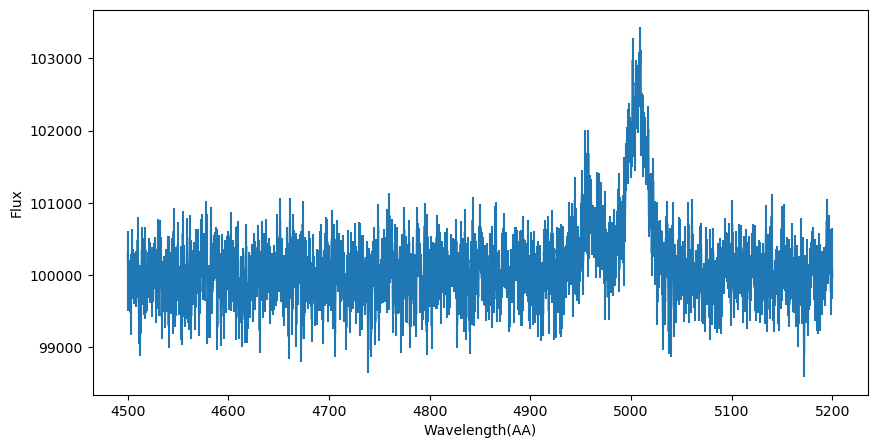

In [2]:
# Let's load the data and visualise them 
data = np.loadtxt('data_spec_01.txt')
f = plt.figure(figsize=(10,5))
lbda, flux, sigma_flux = data[:,0], data[:,1], data[:,2]
plt.errorbar(lbda, flux, sigma_flux)
plt.xlabel('Wavelength(AA)')
plt.ylabel('Flux')

In [3]:
# Let's define models for fitting those emission lines
def continuum(x, a, b):
    '''
    Description: 
    f = a * x + b

    Parameters: 
    x: np.array - dependent variable
    a: float  - slope
    b: float - intercept at origin 
    '''
    return a * x + b 

def gauss(x, I0, x0, sigma):
    '''
    Gaussian model
    '''
    y = I0  * np.exp(-0.5 * (x - x0)**2 / sigma**2 )
    return y

def fullmodel(x, a, b, I0_0, x0_0, sigma_0, I0_1, x0_1, sigma_1):
    '''
    Full model 
    '''
    g1 = gauss(x, I0_0, x0_0, sigma_0) 
    g2 = gauss(x, I0_1, x0_1, sigma_1) 
    y = continuum(x, a, b) + g1 + g2
    return y

In [4]:
# Let's do a fit, setting initial conditions from visual inspection
p_model, cov = curve_fit(fullmodel, data[:,0], data[:,1], 
                         p0 = [0.0, 100000, 2000, 4959, 30, 6000, 5007, 30], 
                         sigma=data[:,2], absolute_sigma=True)


y_pred = fullmodel(lbda, *p_model)
nparam = len(p_model)
chi2 = np.sum( ((flux-y_pred) / sigma_flux)**2 ) 
dof = len(flux)-nparam
p_value = 1 - scipy.stats.chi2.cdf(chi2, df= dof) 

print('Model parameters', p_model)
print('chi^2 = %.2f , for %i dof, namely a reduced chi2= %.2f' %(chi2, dof, chi2/dof) )
print('p_value %.3e' % p_value)
print('Covariance matrix : \n', cov)

Model parameters [5.51744958e-02 9.97226078e+04 7.96942606e+02 4.95980180e+03
 1.13047905e+01 2.46952890e+03 5.00629981e+03 9.93133901e+00]
chi^2 = 1024.89 , for 992 dof, namely a reduced chi2= 1.03
p_value 2.281e-01
Covariance matrix : 
 [[ 2.63985303e-03 -1.27446493e+01 -3.01433036e-01 -4.65269469e-05
  -4.83460030e-03 -3.72304387e-01 -5.79075661e-04 -2.20030165e-03]
 [-1.27446493e+01  6.16453741e+04  1.35923667e+03  5.00501410e-01
   2.15157862e+01  1.70150896e+03  2.69859572e+00  1.01217261e+01]
 [-3.01433036e-01  1.35923667e+03  5.43615048e+03 -1.87198239e+00
  -5.05953971e+01 -5.94769894e+01 -1.67111053e+00  3.31139367e+00]
 [-4.65269469e-05  5.00501410e-01 -1.87198239e+00  1.44374945e+00
   6.15232610e-02  5.12784290e+00  3.38511807e-02 -6.30199506e-02]
 [-4.83460030e-03  2.15157862e+01 -5.05953971e+01  6.15232610e-02
   1.56510564e+00  1.04295952e+01  7.06670588e-02 -9.67544781e-02]
 [-3.72304387e-01  1.70150896e+03 -5.94769894e+01  5.12784290e+00
   1.04295952e+01  6.16683916e

Text(0, 0.5, 'Normalised residuals')

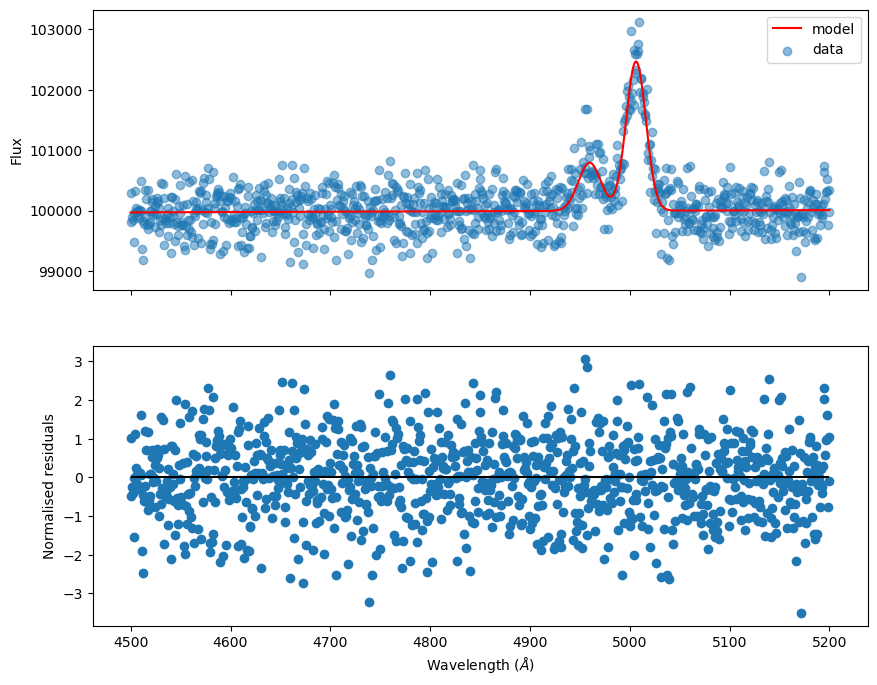

In [5]:
# looking at the normalised residuals
y_pred = fullmodel(lbda, *p_model)
residual = (flux-y_pred) / sigma_flux  # normalised residuals 
f, ax = plt.subplots(nrows=2, figsize=(10,8), sharex=True)
ax[0].scatter(lbda, flux, alpha=0.5, label='data')
ax[0].plot(lbda, y_pred, color='red', label='model')
ax[0].legend()
ax[1].scatter(lbda, residual)
ax[1].hlines(0, lbda.min(), lbda.max())
ax[0].set_ylabel('Flux')
ax[1].set_xlabel('Wavelength ($\AA$)')
ax[1].set_ylabel('Normalised residuals')

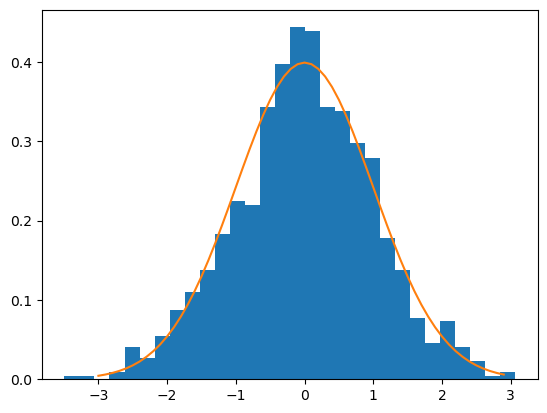

In [6]:
# We can also look at the normalised histogram
plt.hist(residual, bins=30, density = True);
n = scipy.stats.norm()
plt.plot(np.arange(-3,3,0.1), n.pdf(np.arange(-3,3,0.1)))  # Verify that it is N(0,1)

In [7]:
# line intensity ratio (only on the peak of the line flux)
print("peak flux of line 1 and line 2 = %.3f, %.3f "%(p_model[2], p_model[5]))
print("line ratio = %.3f " % (p_model[5] / p_model[2] ))

peak flux of line 1 and line 2 = 796.943, 2469.529 
line ratio = 3.099 


To calculate the uncertainty on the flux ratio we need to apply the error propagation formula for $ c = b / a$
$$
\left(\frac{\sigma_c}{c} \right)^2 = \left(\frac{\sigma_a}{a} \right)^2 + \left(\frac{\sigma_b}{b} \right)^2 - 2 \, \left(\frac{\sigma_{ab}}{ab} \right)
$$


In [8]:
I_line2 = p_model[5]
var_line2 = cov[5,5]
I_line1 = p_model[2]
var_line1 = cov[2,2]
cov_Iline12 = cov[5,2]
line_ratio = p_model[5] / p_model[2]
var_ratio = line_ratio**2 * (var_line2 / I_line2**2 + var_line1 / I_line1**2 - (2. * cov_Iline12 / (I_line1 * I_line2)))
stde_line_ratio = np.sqrt(var_ratio)

In [9]:
print('Line ratio =%.3f +/- %.3f' %(line_ratio, stde_line_ratio))

Line ratio =3.099 +/- 0.304


In [10]:
# What would be the uncertainty if we had ignored the covariance
var_ratio_nocov = line_ratio**2 * (var_line2 / I_line2**2 + var_line1 / I_line1**2 )
stde_line_ratio_no_cov = np.sqrt(var_ratio_nocov)
print('Comparison of uncertainties with and without covariance: %.2e vs %.2e'%(stde_line_ratio, stde_line_ratio_no_cov))

Comparison of uncertainties with and without covariance: 3.04e-01 vs 3.03e-01


For this specific case, the impact of the covariance on the line-ratio uncertainty is tiny. 

## More realistic situation 

Dealing with a situation where the noise has not been estimated but where we know that the uncertainty is poissoninan. This means that the standard uncertainty on the data points is proportional to $\sqrt{F}$, where F is the input flux. 

In [11]:
data_ps = np.loadtxt('data_spec_01_nosigma.txt')

Text(0, 0.5, 'Flux')

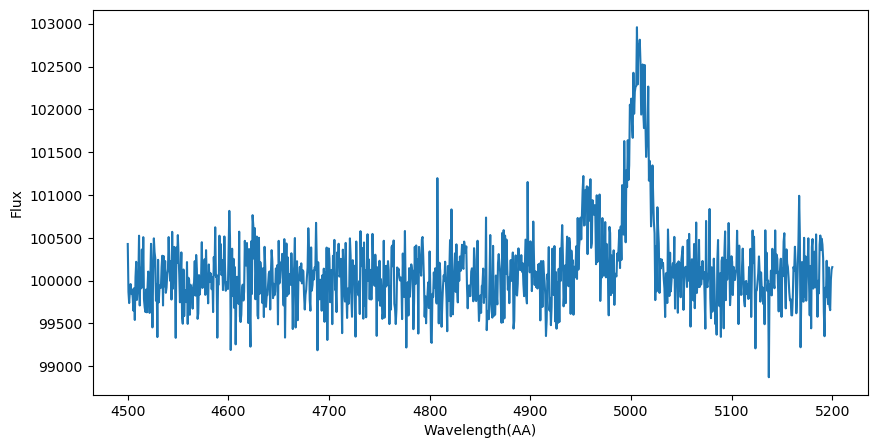

In [12]:
# Let's visualise de data
f = plt.figure(figsize=(10,5))
plt.plot(data_ps[:,0], data_ps[:,1])
plt.xlabel('Wavelength(AA)')
plt.ylabel('Flux')

We proceed in two steps to estimate the noise: 
- step 1: estimate a smooth model of the data
- step 2: remove the smooth model from the data to evaluate the noise 

We will evaluate the smooth model by doing a least square fit on the data. Alternative exist, such as methods involving filtering the data. 

In [13]:
p_model, cov = curve_fit(fullmodel, data_ps[:,0], data_ps[:,1], 
                         p0 = [0.05, 9972., 800., 4959.8, 10, 2400, 5007, 10])

y_pred = fullmodel(data_ps[:,0], *p_model)
nparam = len(p_model)

print('Model parameters', p_model)


Model parameters [6.32882505e-02 9.97054150e+04 8.57555875e+02 4.95800549e+03
 8.65772970e+00 2.48364106e+03 5.00733274e+03 9.49774357e+00]


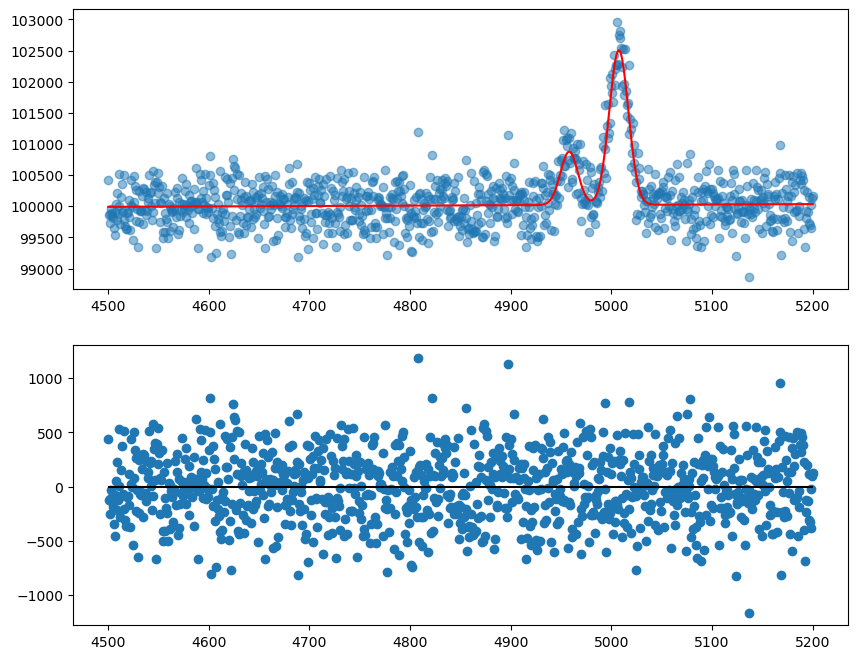

In [14]:
y_pred = fullmodel(data_ps[:,0], *p_model)
residual = (data_ps[:,1]-y_pred)

f, ax = plt.subplots(nrows=2, figsize=(10,8))
ax[0].scatter(data_ps[:,0], data_ps[:,1], alpha=0.5)
ax[0].plot(data_ps[:,0], y_pred, color='red')
ax[1].scatter(data_ps[:,0], residual)
ax[1].hlines(0, data_ps[:,0].min(), data_ps[:,0].max())

Text(0.5, 0, 'Residual')

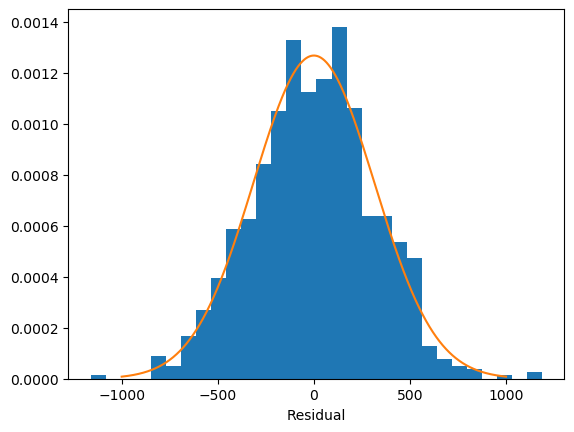

In [15]:
# We can also look at the normalised histogram
plt.hist(residual, bins=30, density = True);
nfit = scipy.stats.norm.fit(residual)
n = scipy.stats.norm(*nfit)
xx = np.arange(-1000,1000,0.5)
plt.plot(xx, n.pdf(xx))  # Verify that it is well approximated by a Gaussian
plt.xlabel('Residual')

It may not be a perfect gaussian but it is not far ... In any case, we do not have too much choice to evaluate a noise based on the residuals. 

In [16]:
# Knowing that the noise is poissonian, I would use the sqrt() of the previous model as my estimate of the noise 
sigma_estimate = np.sqrt(y_pred)
p_model2, cov2 = curve_fit(fullmodel, data_ps[:,0], data_ps[:,1], 
                         sigma=sigma_estimate, 
                           p0 = [0.05, 9972., 800., 4959.8, 10, 2400, 5007, 10],
                          absolute_sigma=True)

In [17]:
y_pred2 = fullmodel(data_ps[:,0], *p_model2)
nparam = len(p_model2)
chi2 = np.sum(( (data_ps[:,1]-y_pred2)/sigma_estimate)**2) 
p_value = scipy.stats.chi2.sf(chi2, df= len(data_ps[:,1])-nparam) 

print('Model parameters', p_model2)
print('chi^2 = %.2f , for %i dof, namely a reduced chi2= %.2f' %(chi2, len(data_ps[:,0])-(nparam), chi2/(len(data_ps[:,0])-(nparam))))
print('p_value %.3e' % p_value)
#print('Covariance matrix : \n', cov)

Model parameters [6.32905301e-02 9.97054048e+04 8.57578630e+02 4.95800763e+03
 8.65728766e+00 2.48368011e+03 5.00733146e+03 9.49757084e+00]
chi^2 = 988.59 , for 992 dof, namely a reduced chi2= 1.00
p_value 5.246e-01


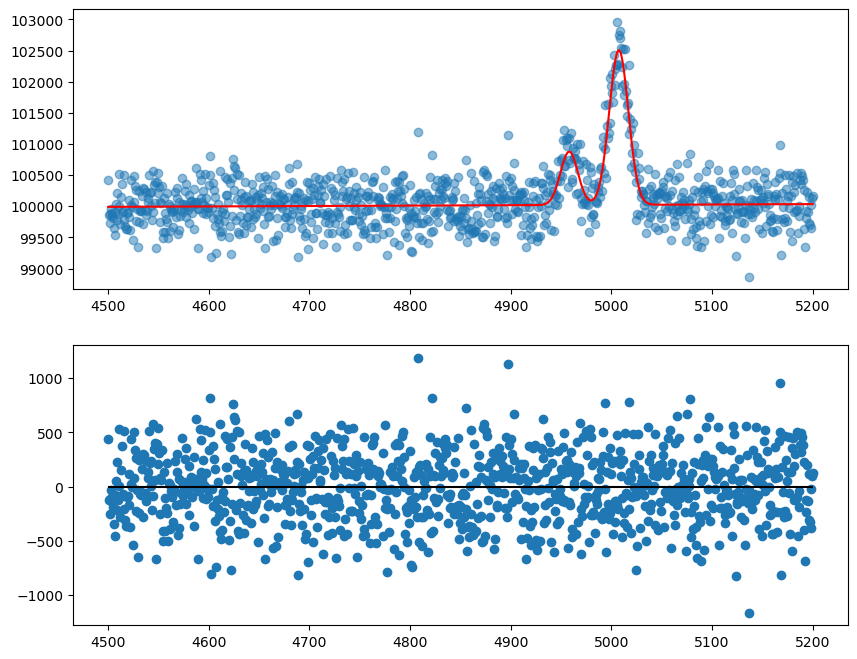

In [18]:
residual2 = (data_ps[:,1]-y_pred2)
f, ax = plt.subplots(nrows=2, figsize=(10,8))
ax[0].scatter(data_ps[:,0], data_ps[:,1], alpha=0.5)
ax[0].plot(data_ps[:,0], y_pred2, color='red')
ax[1].scatter(data_ps[:,0], residual2)
ax[1].hlines(0, data_ps[:,0].min(), data_ps[:,0].max())

Everything indicates that the fit is good so we can move forward to evaluate the uncertainty on the line ratio as in the first part 

In [19]:
# Now we can calculate the uncertainty 
I_line2 = p_model2[5]
var_line2 = cov2[5,5]
I_line1 = p_model2[2]
var_line1 = cov2[2,2]
cov_Iline12 = cov2[5,2]
line_ratio2 = p_model2[5] / p_model2[2]
var_ratio_ps = line_ratio**2 * (var_line2 / I_line2**2 + var_line1 / I_line1**2 - (2. * cov_Iline12 / (I_line1 * I_line2)))
stde_line_ratio2 = np.sqrt(var_ratio_ps)
print('Line ratio =%.3f +/- %.3f' %(line_ratio2, stde_line_ratio2))

Line ratio =2.896 +/- 0.318


## One step Beyond: Monte-Carlo simulation 

We use Monte-Carlo simulations to estimate the uncertainty on the flux ratio of the integrated line flux. 

Strictly speaking, Monte Carlo simulations are NOT needed to make this evaluation as the integrated line flux can be calculated analytically and error propagation formula be used. However, we may still want to verify that the final uncertainty is Gaussian, which is not guaranteed. 

The idea is to use the results of the model to generate simulated profiles (accounting for the covariances), numerically integrate the line fluxes and calculate the flux ratios. (note that there is no need to do add noise and do the fit on the simulated profiles).  

In [20]:
# Let's work on the results obtained for the Poisson noise data (the same method would be used for the other data set)
# We will calculate total line fluxes for mock profiles drawn from a multivariate gaussian with covariance matrix given by the model
 
Norm_nd = scipy.stats.multivariate_normal(p_model2, cov=cov2, allow_singular=True)

# Note here the "allow_singular" argument despite that the matrix is not singular. 
# Not putting this argument yields an error message in the present case. 
# The help of scipy.stats.multivariate_normal() indicates that the cov. matrix should be symmetric positive semidefinite 
# While the eigenvalues of cov2 are effectively > 0, the matrix is not found to be symmetric due to rounding uncertainties 
# is_symmetric = np.array_equal(cov2, cov2.T) 
# The argument allow_singular=True is a fix to those rounding uncertainties   

In [21]:
Nsim = 10000
psim = Norm_nd.rvs(size=Nsim)
psim.shape

(10000, 8)

In [22]:
lamb = np.arange(4000, 6000)
Itot12 = np.zeros(shape=(Nsim, 2))
for i in range(Nsim):
    Gauss1 = gauss(lamb, *psim[i, 2:5])
    Gauss2 = gauss(lamb, *psim[i, 5:8])
    Itot12[i, 0] = np.trapz(Gauss1, lamb)
    Itot12[i, 1] = np.trapz(Gauss2, lamb)

Text(0.5, 0, 'I2 / I1 ')

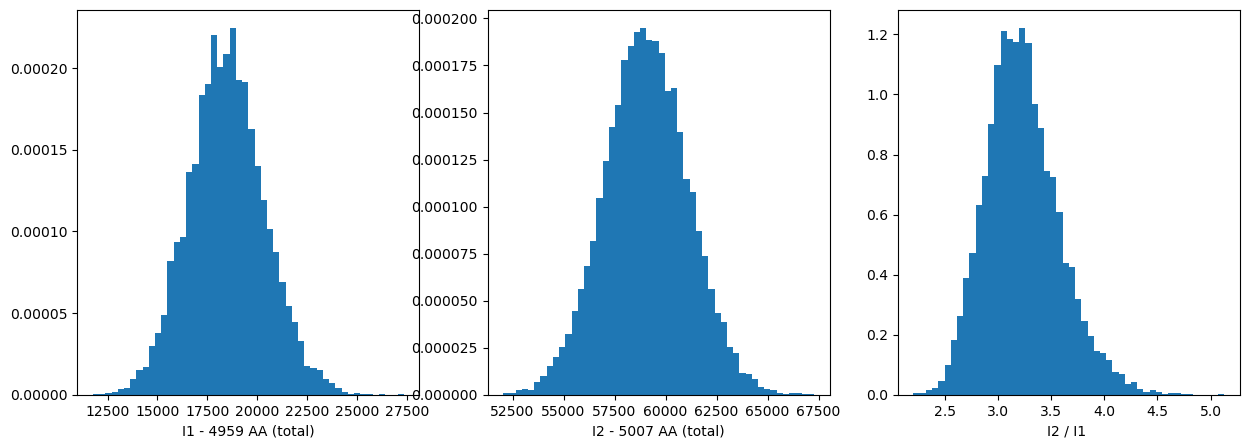

In [23]:
f, ax = plt.subplots(ncols=3, figsize=(15,5));
ax[0].hist(Itot12[:,0], bins=50, density=True)
ax[1].hist(Itot12[:,1], bins=50, density=True)
ax[2].hist(Itot12[:,1] / Itot12[:,0], bins=50, density=True);
ax[0].set_xlabel('I1 - 4959 AA (total)')
ax[1].set_xlabel('I2 - 5007 AA (total)')
ax[2].set_xlabel('I2 / I1 ')

Text(0, 0.5, 'I1 - 4959 AA (total)')

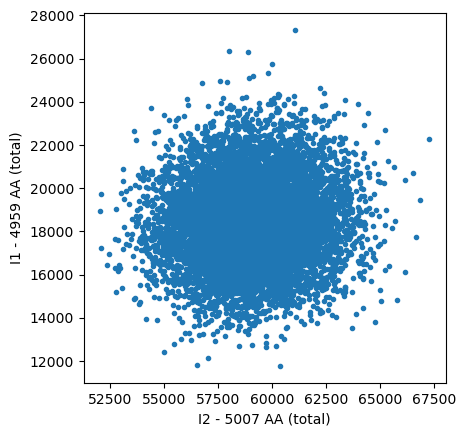

In [24]:
f, ax = plt.subplots()
ax.scatter(Itot12[:,1], Itot12[:,0], marker='.')
ax.set_aspect('equal')
ax.set_xlabel('I2 - 5007 AA (total)')
ax.set_ylabel('I1 - 4959 AA (total)')

In [25]:
# Is there covariance between I1 and I2? 
var_Itot1 = np.var(Itot12[:,0])
Itot1_av = np.mean(Itot12[:,0])
var_Itot2 = np.var(Itot12[:,1])
Itot2_av = np.mean(Itot12[:,1])
var_Iratio = np.var(Itot12[:,1] / Itot12[:,0])
Iratio_av = np.mean(Itot12[:,1] / Itot12[:,0])
cov_Itot1_Itot2 = (np.sum( (Itot12[:,0] - Itot1_av) * (Itot12[:,1] - Itot2_av)) ) / Nsim
print(var_Itot1, var_Itot2, cov_Itot1_Itot2, var_Iratio)

3580482.2249114914 4198451.478272 268706.20100201597 0.12137168618347989


=> There is maybe a small covariance but 20 times less than the variance ... 

In [26]:
# We can use Pearson coefficient of determination to check out the significance of the covariance
# In fact, we do not really need this, we can increase the number of monte-carlo samples. 
# np.corrcoef(Itot12[:,1], Itot12[:,0])  # this only gives the correlation matrix 
pearsonr, pval = scipy.stats.pearsonr(Itot12[:,1], Itot12[:,0])  # this returns r and a p value
stde_r = np.sqrt((1-pearsonr**2) / (Nsim - 2 ))
print(pearsonr, stde_r, pval )

0.0693046474555896 0.009976953167325496 3.978554488091472e-12


The coefficient of determination is small, but is significantly different of 0, confirming that the 2 data sets are not drawn from 2 independant univariate Gaussians. Note here that the conclusions would be less clear with e.g. 10 times less simulations. 

In [28]:
# What value of the variance on the flux ration would we have obtained 
# if we had used the error propagation formula -with and without covariance- 
var_ratio_nocov = Iratio_av**2 * (var_Itot1 / Itot1_av**2 + var_Itot2 / Itot2_av**2) 
# Now calculated properly with cov. 
var_ratio = Iratio_av**2 * (var_Itot1 / Itot1_av**2 + var_Itot2 / Itot2_av**2 - 2 * cov_Itot1_Itot2 / (Itot1_av * Itot2_av) )
# and directly from the MC simulations 
var_MC = np.var(Itot12[:,1] / Itot12[:,0])
#
print("No cov: %.4f, With cov: %.4f, Monte Carlo: %.4f"%(var_ratio_nocov, var_ratio, var_MC))

No cov: 0.1220, With cov: 0.1169, Monte Carlo: 0.1214


This shows that the covariance has a small impact. At first sight, it may even suggest that the covariance should not be accounted for ... but this is wrong. The histogram of the MC shows that the distribution is not gaussian and the estimated variance by using np.var() from the histogram is biased high. => The uncertainties should ideally be based on the histogram of flux ratios from the MC simulations. Some percentiles uncertainties / Confidence Interval could be derived from that.